In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [3]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scanpy as sc

In [4]:
adata = sc.read("../../../data/adata_pancreas_2019_processed_new.h5ad")

In [5]:
sc.pp.pca(adata, n_comps=10)

In [6]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"].copy()

In [7]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=10, iterations=5000)

In [8]:
kg(source, target)

100%|██████████| 5000/5000 [53:56<00:00,  1.54it/s]


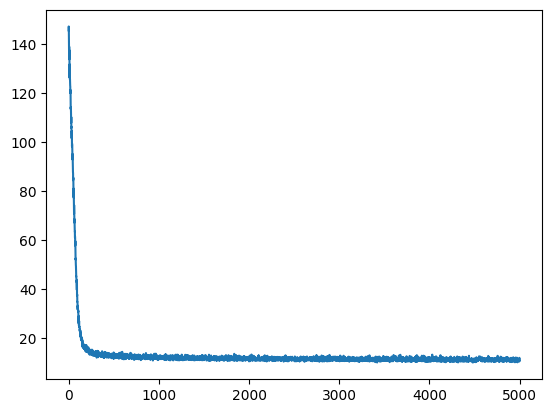

In [9]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

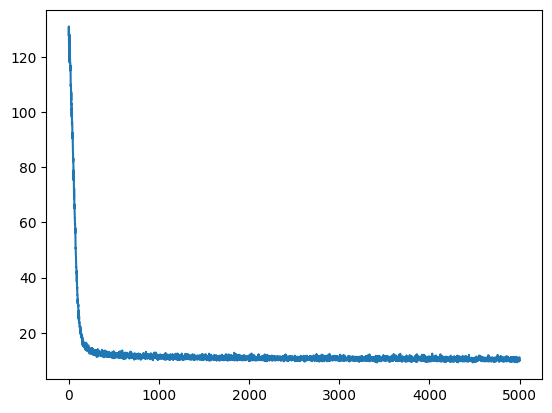

In [10]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

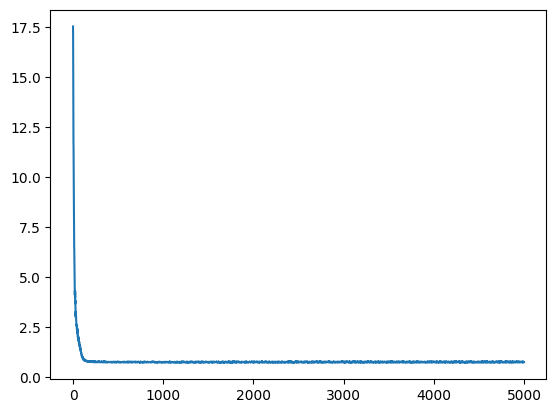

In [11]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [12]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))

In [13]:
source_with_noise = jnp.concatenate((source, noise), axis=1)

In [14]:
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

In [15]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [16]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/d

In [17]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


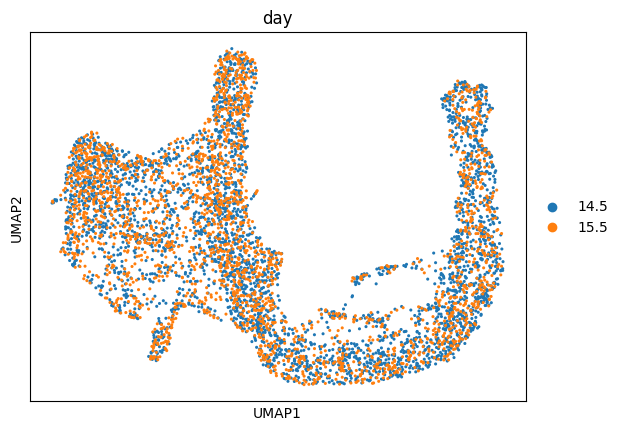

In [18]:
sc.pl.umap(bdata, color="day")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


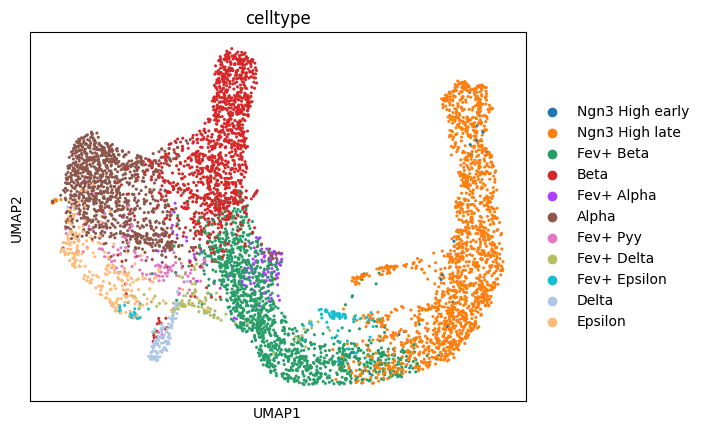

In [19]:
sc.pl.umap(bdata, color="celltype")

In [20]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [21]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [22]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


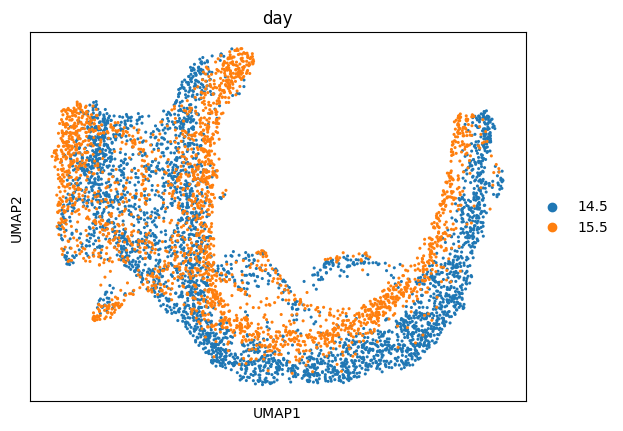

In [23]:
sc.pl.umap(adata, color="day")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


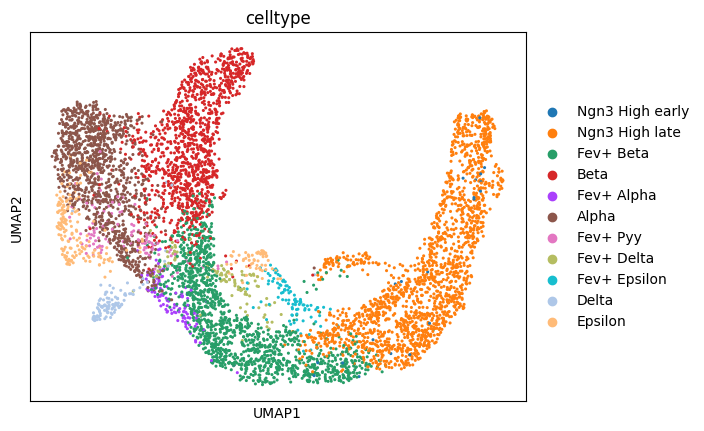

In [24]:
sc.pl.umap(adata, color="celltype")

In [25]:
res = [None] * 15

for i in range(15):
    noise = jax.random.normal(jax.random.PRNGKey(i), shape=(len(source), 4))
    source_with_noise = jnp.concatenate((source, noise), axis=1)
    res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)


In [26]:
samples = jnp.array(res)

In [27]:
samples.shape

(15, 3575, 10)

In [28]:
vars = jnp.var(samples, axis=0)

In [29]:
vars_summed = jnp.sum(vars, axis=1)

In [30]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

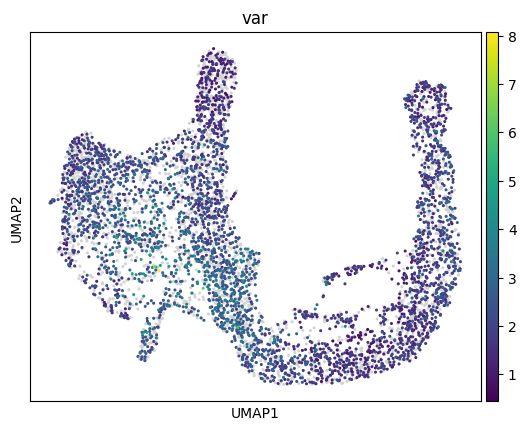

In [31]:
sc.pl.umap(bdata, color="var")

In [38]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,1.419007
Ngn3 High late,1.722344
Fev+ Beta,2.190915
Beta,1.862259
Fev+ Alpha,2.870193
Alpha,2.214432
Fev+ Pyy,2.969546
Fev+ Delta,2.578724
Fev+ Epsilon,1.627514


In [73]:
cdata = bdata[~bdata.obs["celltype"].isin(["Acinar", "Ductal", "Tip", "Trunk", "Multipotent", "Ngn3 low EP"])].copy()

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


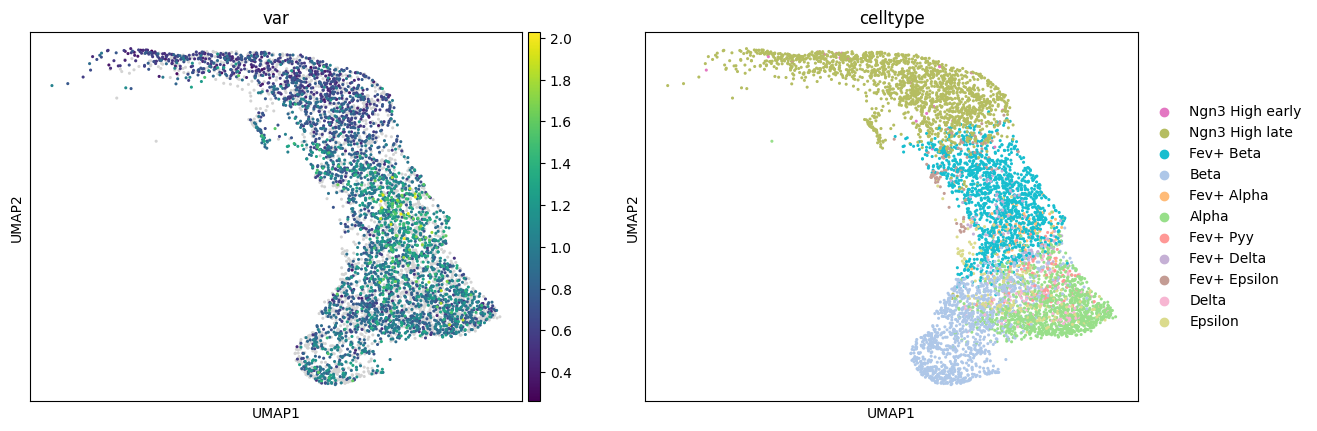

In [75]:
sc.pl.umap(cdata, color=["var", "celltype"])

In [76]:
sc.pp.neighbors(cdata, use_rep="X_pca_result")

In [77]:
sc.tl.umap(cdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


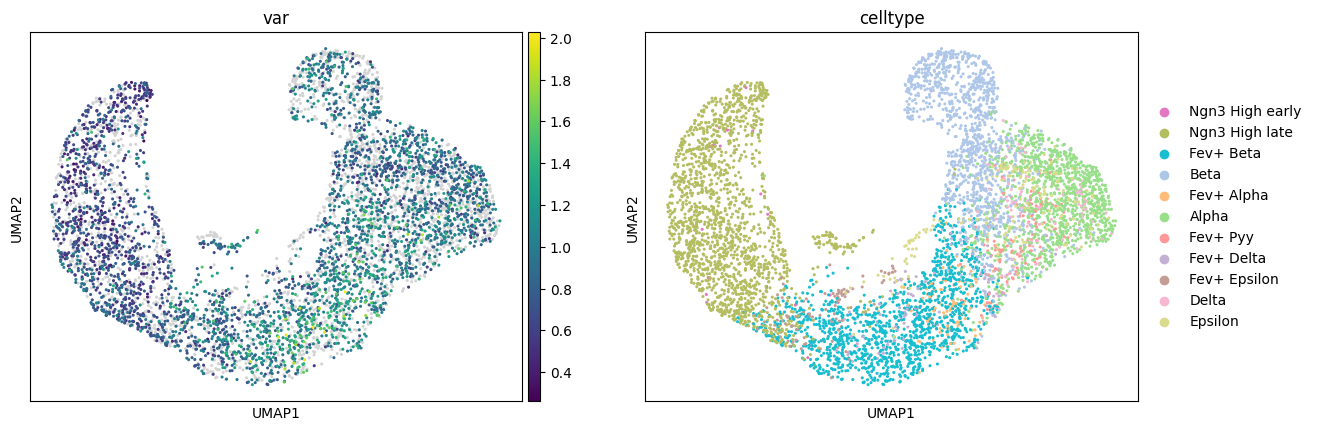

In [79]:
sc.pl.umap(cdata, color=["var", "celltype"])

Variance p(Y|X=0.5) is 0.10


<Axes: ylabel='Density'>

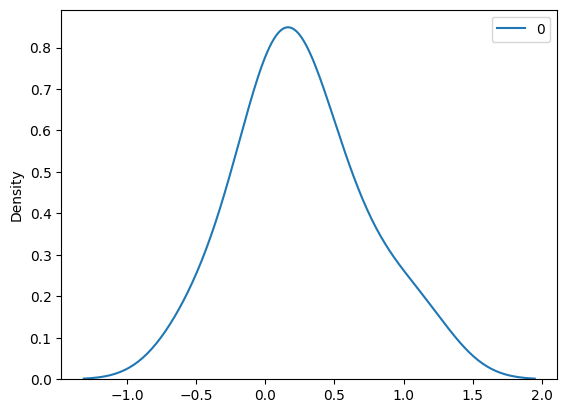

In [19]:
sample_05 = sm.sample(jnp.array([0.5]))
print(f"Variance p(Y|X=0.5) is {jnp.var(sample_05):.2f}")
sns.kdeplot(sample_0)